In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from allison.nn.layers import LayerDense
from allison.nn.models import NeuralNetwork
from allison.utils.functions.data import train_test_split
from allison.utils.functions.activation import sigmoid,softmax,tanh,relu
from allison.utils.metrics import r2_score
from allison.utils.functions.loss import mean_squared_error

Dataset

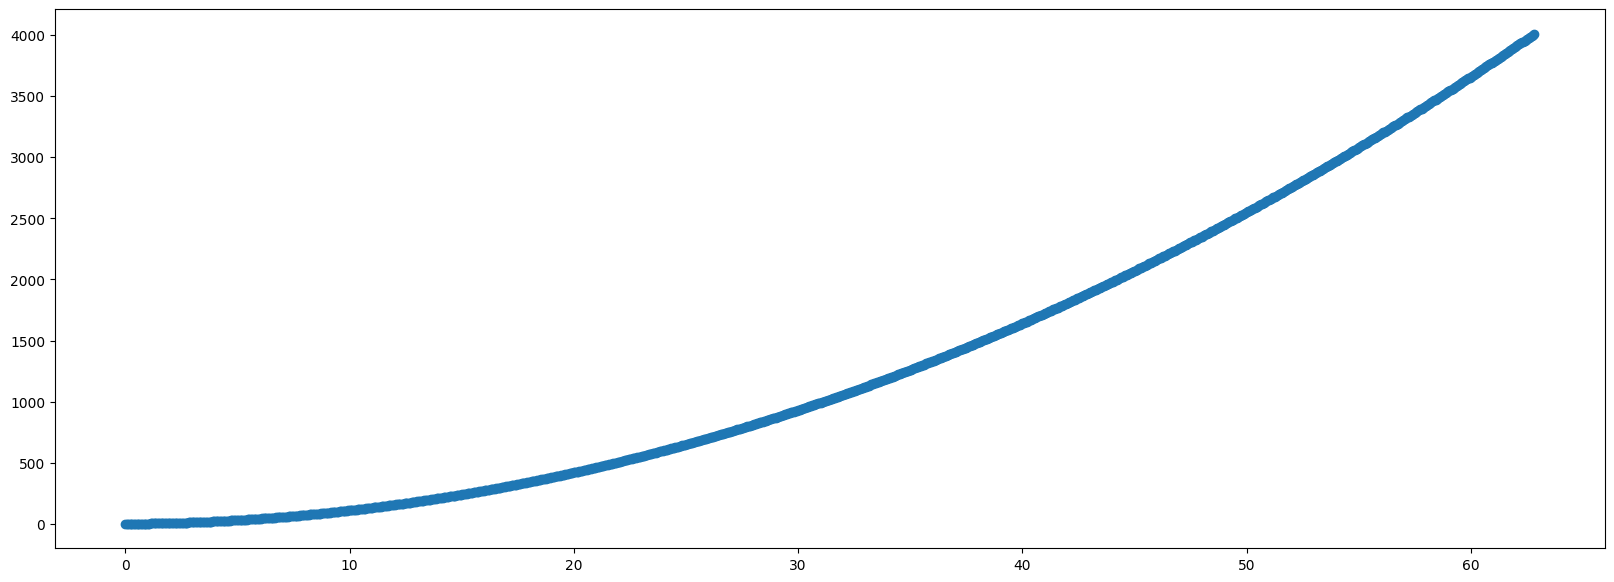

In [2]:
points = 1000

x1 = np.linspace(0,20*np.pi,points)
x2 = np.linspace(0,20*np.pi,points)

y =  x1**2 + x2

plt.figure(figsize=(20, 7))
plt.scatter(x2, y)

In [3]:

df=pd.DataFrame({
    "x1":x1,
    'x2':x2,
    "y":y,
})
df.head()

,x1,x2,y
0,0.000000,0.000000,0.000000
1,0.062895,0.062895,0.066850
2,0.125789,0.125789,0.141612
3,0.188684,0.188684,0.224286
4,0.251579,0.251579,0.314871


# Preprocess

Split data for train and test

In [4]:
data_train, data_test = train_test_split(df,test_size=0.2)
features = ["x1","x2"]
labels = "y"

X_train = data_train[features].to_numpy()
Y_train=data_train[labels].to_numpy(int)
print(X_train.shape,Y_train.shape)

X_test = data_test[features].to_numpy()
Y_test=data_test[labels].to_numpy(int)
print(X_test.shape,Y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


# Train

In [20]:
model = NeuralNetwork(mean_squared_error,r2_score, 0.0000000000005)
model.add_layer(LayerDense(2,2,relu))
model.add_layer(LayerDense(2,2,relu))
model.add_layer(LayerDense(2,1,relu))
model.summary()

Layer:1, neurons:2, input:(n,2), weights:(2,2), output:(n,2), activation:relu 

Layer:2, neurons:2, input:(n,2), weights:(2,2), output:(n,2), activation:relu 

Layer:3, neurons:1, input:(n,2), weights:(2,1), output:(n,1), activation:relu 

Total -> Layers:3, neurons:5, weights:10, bias:5 params:15 

Loss function: mean_squared_error 

Metric: r2_score 

Learning Rate: 5e-13 



In [23]:
steps = 100
iters = 10

accuracy_train = 0
accuracy_test = 0

for step in range(1,steps+1):
    if accuracy_train > 95.0 and accuracy_test > 95.0:
        break
    model.train(X_train,Y_train,iters,False)
    
    accuracy_train = model.evaluate(X_train,Y_train)
    accuracy_test = model.evaluate(X_test,Y_test)

    print(f"Step: {step:3d} R2_train: {accuracy_train:7.3f}% R2_test: {accuracy_test:7.3f}%")

Step:   1 R2_train:  59.572% R2_test:  66.128%
Step:   2 R2_train:  59.572% R2_test:  66.128%
Step:   3 R2_train:  59.572% R2_test:  66.128%
Step:   4 R2_train:  59.572% R2_test:  66.128%
Step:   5 R2_train:  59.572% R2_test:  66.128%
Step:   6 R2_train:  59.572% R2_test:  66.128%
Step:   7 R2_train:  59.572% R2_test:  66.128%
Step:   8 R2_train:  59.572% R2_test:  66.128%
Step:   9 R2_train:  59.572% R2_test:  66.128%
Step:  10 R2_train:  59.572% R2_test:  66.128%
Step:  11 R2_train:  59.572% R2_test:  66.128%
Step:  12 R2_train:  59.572% R2_test:  66.128%
Step:  13 R2_train:  59.572% R2_test:  66.128%
Step:  14 R2_train:  59.572% R2_test:  66.128%
Step:  15 R2_train:  59.572% R2_test:  66.128%
Step:  16 R2_train:  59.572% R2_test:  66.128%
Step:  17 R2_train:  59.572% R2_test:  66.128%
Step:  18 R2_train:  59.572% R2_test:  66.128%
Step:  19 R2_train:  59.572% R2_test:  66.128%
Step:  20 R2_train:  59.572% R2_test:  66.128%
Step:  21 R2_train:  59.572% R2_test:  66.128%
Step:  22 R2_

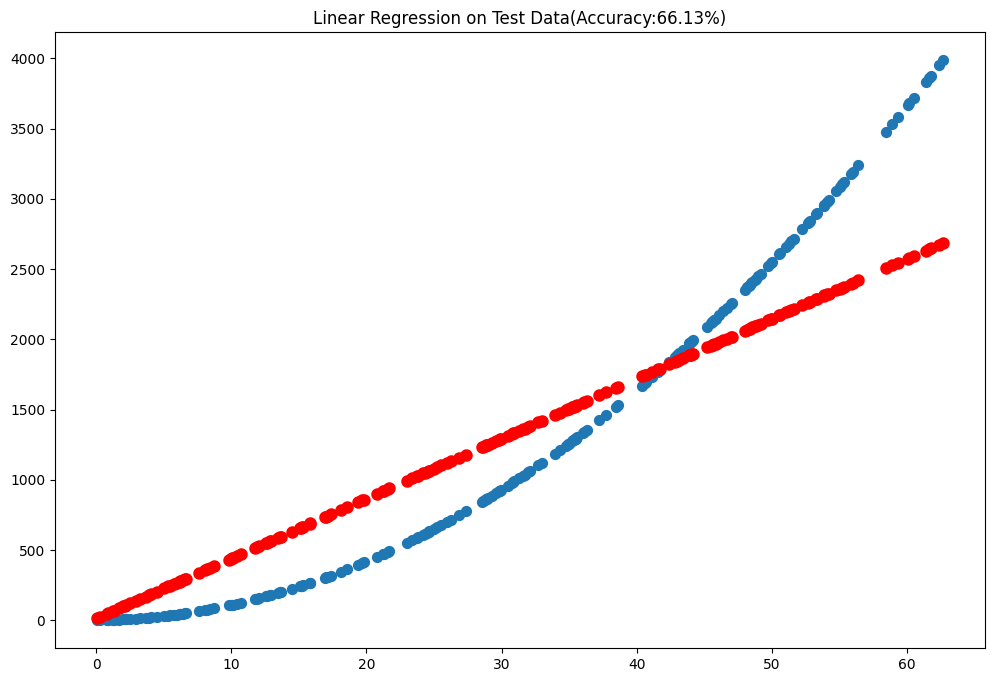

In [24]:
plt.figure(figsize=(12,8))

plt.scatter(X_test[:,0],Y_test,s=50)
plt.scatter(X_test[:,0],model.predict(X_test), lw=3, c='red')
plt.title(f'Linear Regression on Test Data(Accuracy:{model.evaluate(X_test, Y_test):.2f}%)')
plt.show()